<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/NGupta_homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip

In [0]:
# !unzip 'sentiment labelled sentences.zip'

In [0]:
import os
from typing import List, Tuple
import numpy as np
import pandas as pd

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
files = ['amazon_cells_labelled.txt', 'yelp_labelled.txt', 'imdb_labelled.txt']
parent_dir = 'sentiment labelled sentences'
dfs = [pd.read_csv(os.path.join(parent_dir, file), delimiter='\t', header=None) for file in files]
len(dfs)

3

In [0]:
# Combine all data sets
data = pd.concat(dfs)
data.columns = ['Sentence','Sentiment']
data.reset_index(inplace=True, drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   2748 non-null   object
 1   Sentiment  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [0]:
data.head()

,Sentence,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [0]:
data.tail()

,Sentence,Sentiment
2743,I just got bored watching Jessice Lange take h...,0
2744,"Unfortunately, any virtue in this film's produ...",0
2745,"In a word, it is embarrassing.",0
2746,Exceptionally bad!,0
2747,All in all its an insult to one's intelligence...,0


### Looks like the data is evenly distributed between both positive and negative sentiment

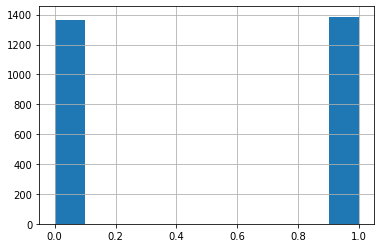

In [0]:
data['Sentiment'].hist()

# Preprocessing

* [Reference](https://dzone.com/articles/simple-sentiment-analysis-with-nlp)

In [0]:
for i in range(5):
  print(data.iloc[i]['Sentence'])

So there is no way for me to plug it in here in the US unless I go by a converter.
Good case, Excellent value.
Great for the jawbone.
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
The mic is great.


In [0]:
#Text Preprocessing
# Lower string
data['Sentence'] = data['Sentence'].str.lower()

# Remove punctaitions and special chracters
data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')

# Remove numbers 
# Reasons: 
# (1) They can have a large range (vocabulary will unnecessarily increase)
# (2) They dont add much to determine the polarity of the sentiment (e.g. if a review contains 45, does it mean that the review is positive or negative?)
data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)

In [0]:
for i in range(5):
  print(data.iloc[i]['Sentence'])

so there is no way for me to plug it in here in the us unless i go by a converter
good case excellent value
great for the jawbone
tied to charger for conversations lasting more than  minutesmajor problems
the mic is great


It is not perfect. You can see that "minutes.MAJOR" has been converted to a single token "minutesmajor", when it should have been 2 tokens. But this is still better than the original text.

In [0]:
# Remove Stop Words (using nltk)
df_ = pd.DataFrame(columns=data.columns)

for index, row in data.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"Sentiment":  row['Sentiment'], "Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)

data = df_

In [0]:
for i in range(5):
  print(data.iloc[i]['Sentence'])

way plug us unless go converter
good case excellent value
great jawbone
tied charger conversations lasting minutesmajor problems
mic great


# EDA

In [0]:
data['len'] = data['Sentence'].str.split().str.len()
data.head()

,Sentence,Sentiment,len
0,way plug us unless go converter,0,6
1,good case excellent value,1,4
2,great jawbone,1,2
3,tied charger conversations lasting minutesmajo...,0,6
4,mic great,1,2


In [0]:
print('Maximum review length: {}'.format(data['len'].max()))
print('Minimum review length: {}'.format(data['len'].min()))

Maximum review length: 686
Minimum review length: 0


In [0]:
data[data['len'] == 0]

,Sentence,Sentiment,len
2064,,1,0
2590,,1,0


In [0]:
# Remove empty reviews since these will translate to all <PAD> tokens and we do not want to assign a positive or negative connotation to <PAD> tokens.
data = data[data['Sentence'] != ""]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   2746 non-null   object
 1   Sentiment  2746 non-null   object
 2   len        2746 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 85.8+ KB


In [0]:
print('Maximum review length: {}'.format(data['len'].max()))
print('Minimum review length: {}'.format(data['len'].min()))

Maximum review length: 686
Minimum review length: 1


In [0]:
# Keep 97% of reviews completely and chop of the remainig 3% of the reviews.
import numpy as np
time_steps = int(np.quantile(data['len'],0.97))
time_steps

15

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1bbf576da0>]],
      dtype=object)

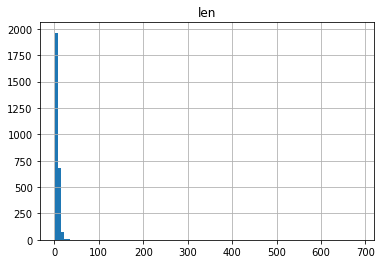

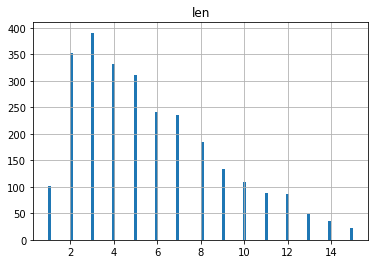

In [0]:
data.hist(bins=100)
data[data['len'] <= time_steps].hist(bins=100)

# Train Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Sentiment'].values.astype('int32'),
    test_size=0.20,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_test)}, y_test: {len(y_test)}")

Number of samples: X_train: 2196, y_train: 2196
Number of samples: X_test: 550, y_test: 550


In [0]:
# Checking split --> both test and train contain roughly the same number of positive (and negative) sentiment reviews
print(sum(y_train == 1)/len(y_train))
print(sum(y_test == 1)/len(y_test))

0.51183970856102
0.4727272727272727


In [0]:
sentiments  = data['Sentiment'].unique()
sentiments

array([0, 1], dtype=object)

In [0]:
X_train[:5]

array(['great tool entertainment communication data managementoh sure use activesync optimal data synchronization results',
       'frankly cotton club unfaithful kind embarrassing watch lane gere film bad',
       'keyboard really worthwhile usefulness sturdy enough dont expect problems',
       'utterly confusing first caused lose couple important contacts',
       'wish could enter negative values admins'], dtype='<U4999')

In [0]:
reviews_corpus = []
for _, row in enumerate(X_train):
  reviews_corpus = reviews_corpus + row.split(" ")

print(reviews_corpus[:30])

['great', 'tool', 'entertainment', 'communication', 'data', 'managementoh', 'sure', 'use', 'activesync', 'optimal', 'data', 'synchronization', 'results', 'frankly', 'cotton', 'club', 'unfaithful', 'kind', 'embarrassing', 'watch', 'lane', 'gere', 'film', 'bad', 'keyboard', 'really', 'worthwhile', 'usefulness', 'sturdy', 'enough']


In [0]:
# Get only words that have occured more than once to remove noise, spelling mistakes and possible tokenization errors.
fdist = nltk.FreqDist(reviews_corpus)
print(fdist.most_common())
vocab = [word for word, count in fdist.most_common() if count > 1]
print(vocab)

[('good', 183), ('great', 176), ('movie', 142), ('film', 131), ('phone', 124), ('one', 118), ('food', 101), ('like', 96), ('time', 90), ('really', 87), ('place', 87), ('service', 85), ('well', 76), ('bad', 73), ('dont', 71), ('best', 67), ('even', 67), ('would', 66), ('ever', 63), ('also', 56), ('back', 55), ('quality', 54), ('ive', 51), ('go', 51), ('im', 50), ('love', 48), ('made', 48), ('get', 46), ('works', 44), ('could', 43), ('much', 43), ('never', 42), ('product', 42), ('nice', 42), ('better', 42), ('excellent', 41), ('first', 40), ('work', 40), ('think', 40), ('battery', 40), ('sound', 40), ('recommend', 38), ('headset', 38), ('use', 37), ('didnt', 36), ('make', 35), ('acting', 34), ('say', 33), ('see', 33), ('way', 33), ('characters', 32), ('two', 31), ('little', 31), ('worst', 30), ('still', 30), ('thing', 30), ('ear', 30), ('enough', 29), ('terrible', 29), ('price', 29), ('going', 29), ('people', 29), ('everything', 28), ('every', 28), ('story', 27), ('amazing', 27), ('case'

In [0]:
len(vocab)

1793

In [0]:
word_index = {}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
for index, word in enumerate(vocab):
  word_index[word] = index+3

print(word_index)

{'<PAD>': 0, '<START>': 1, '<UNK>': 2, 'good': 3, 'great': 4, 'movie': 5, 'film': 6, 'phone': 7, 'one': 8, 'food': 9, 'like': 10, 'time': 11, 'really': 12, 'place': 13, 'service': 14, 'well': 15, 'bad': 16, 'dont': 17, 'best': 18, 'even': 19, 'would': 20, 'ever': 21, 'also': 22, 'back': 23, 'quality': 24, 'ive': 25, 'go': 26, 'im': 27, 'love': 28, 'made': 29, 'get': 30, 'works': 31, 'could': 32, 'much': 33, 'never': 34, 'product': 35, 'nice': 36, 'better': 37, 'excellent': 38, 'first': 39, 'work': 40, 'think': 41, 'battery': 42, 'sound': 43, 'recommend': 44, 'headset': 45, 'use': 46, 'didnt': 47, 'make': 48, 'acting': 49, 'say': 50, 'see': 51, 'way': 52, 'characters': 53, 'two': 54, 'little': 55, 'worst': 56, 'still': 57, 'thing': 58, 'ear': 59, 'enough': 60, 'terrible': 61, 'price': 62, 'going': 63, 'people': 64, 'everything': 65, 'every': 66, 'story': 67, 'amazing': 68, 'case': 69, 'waste': 70, 'definitely': 71, 'disappointed': 72, 'know': 73, 'minutes': 74, 'far': 75, 'pretty': 76, 

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(reverse_word_index)

{0: '<PAD>', 1: '<START>', 2: '<UNK>', 3: 'good', 4: 'great', 5: 'movie', 6: 'film', 7: 'phone', 8: 'one', 9: 'food', 10: 'like', 11: 'time', 12: 'really', 13: 'place', 14: 'service', 15: 'well', 16: 'bad', 17: 'dont', 18: 'best', 19: 'even', 20: 'would', 21: 'ever', 22: 'also', 23: 'back', 24: 'quality', 25: 'ive', 26: 'go', 27: 'im', 28: 'love', 29: 'made', 30: 'get', 31: 'works', 32: 'could', 33: 'much', 34: 'never', 35: 'product', 36: 'nice', 37: 'better', 38: 'excellent', 39: 'first', 40: 'work', 41: 'think', 42: 'battery', 43: 'sound', 44: 'recommend', 45: 'headset', 46: 'use', 47: 'didnt', 48: 'make', 49: 'acting', 50: 'say', 51: 'see', 52: 'way', 53: 'characters', 54: 'two', 55: 'little', 56: 'worst', 57: 'still', 58: 'thing', 59: 'ear', 60: 'enough', 61: 'terrible', 62: 'price', 63: 'going', 64: 'people', 65: 'everything', 66: 'every', 67: 'story', 68: 'amazing', 69: 'case', 70: 'waste', 71: 'definitely', 72: 'disappointed', 73: 'know', 74: 'minutes', 75: 'far', 76: 'pretty', 

In [0]:
vocabulary_size = len(word_index.keys())
vocabulary_size

1796

In [0]:
def encode_review(plain_text: str) -> List[int]:
  return [word_index[token] if token in word_index.keys() else word_index["<UNK>"] for token in plain_text.split(" ")]

def decode_review(encoded_text):
  return ' '.join([reverse_word_index.get(i, '?') for i in encoded_text])

In [0]:
def encode_decode_check(original_review):
  print("\n")
  print(f"Original Review: ")
  print(original_review)
  encoded_review = encode_review(original_review)
  print(f"Encoded Review: {encoded_review}")
  decoded_review = decode_review(encoded_review)
  print(f"Decoded Review: {decoded_review}")
  same = decoded_review == original_review
  print(f"Decoded = Original: {same}")

## Observations:

* **Train Reviews and test reviews have UNK tokens introduced for words not in the vocabulary, but apart from this, they match up.**

In [0]:
random_train_reviews = X_train[np.random.choice(len(X_train), 5)]
random_train_reviews

for review in random_train_reviews:
  encode_decode_check(review)



Original Review: 
would avoid place staying mirage
Encoded Review: [20, 235, 13, 1338, 2]
Decoded Review: would avoid place staying <UNK>
Decoded = Original: False


Original Review: 
presentation food awful
Encoded Review: [1432, 9, 110]
Decoded Review: presentation food awful
Decoded = Original: True


Original Review: 
best electronics available fm transmitters
Encoded Review: [18, 2, 2, 2, 2]
Decoded Review: best <UNK> <UNK> <UNK> <UNK>
Decoded = Original: False


Original Review: 
someone shouldve invented sooner
Encoded Review: [409, 2, 2, 2]
Decoded Review: someone <UNK> <UNK> <UNK>
Decoded = Original: False


Original Review: 
also taste moms multigrain pumpkin pancakes pecan butter amazing fluffy delicious
Encoded Review: [22, 278, 2, 2, 2, 1732, 2, 875, 68, 2, 114]
Decoded Review: also taste <UNK> <UNK> <UNK> pancakes <UNK> butter amazing <UNK> delicious
Decoded = Original: False


In [0]:
random_test_reviews = X_test[np.random.choice(len(X_test), 5)]
random_test_reviews

for review in random_test_reviews:
  encode_decode_check(review)



Original Review: 
think restaurant suffers trying hard enough
Encoded Review: [41, 124, 2, 346, 220, 60]
Decoded Review: think restaurant <UNK> trying hard enough
Decoded = Original: False


Original Review: 
overall wasnt impressed noca
Encoded Review: [152, 99, 159, 2]
Decoded Review: overall wasnt impressed <UNK>
Decoded = Original: False


Original Review: 
delete film mind
Encoded Review: [2, 6, 785]
Decoded Review: <UNK> film mind
Decoded = Original: False


Original Review: 
doesnt last long
Encoded Review: [126, 163, 111]
Decoded Review: doesnt last long
Decoded = Original: True


Original Review: 
great film great director
Encoded Review: [4, 6, 4, 325]
Decoded Review: great film great director
Decoded = Original: True


In [0]:
X_train_encoded = [encode_review(review) for review in X_train]
X_test_encoded = [encode_review(review) for review in X_test]

In [0]:
from tensorflow.keras.preprocessing import sequence

X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)

In [0]:
X_train_encoded[0:5]

array([[   0,    0,    4,  631,    2,    2,  796,    2,  171,   46,    2,
           2,  796,    2,  797],
       [   0,    0,    0,    0, 1105,    2, 1106,    2,  146,  798,  147,
        1107,    2,    6,   16],
       [   0,    0,    0,    0,    0,    0,  799,   12,  800,    2,  632,
          60,   17,  213,  184],
       [   0,    0,    0,    0,    0,    0,    0,  633,    2,   39,    2,
        1108,  378,  323,  801],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  634,   32,
        1109, 1110,  802,    2]], dtype=int32)

In [0]:
X_test_encoded[0:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 873, 172,
          2,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 135, 138,
          2, 368],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
          2,  16],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
          2, 514],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   2]], dtype=int32)

# RNN

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN as RNN

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4)):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')    

  _ = plt.show

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=10)

In [0]:
# import other libs as needed for building model
from tensorflow.keras.callbacks import ModelCheckpoint

# add a checkpoint to save the lowest validation loss
filepath = '.'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [0]:
def create_simple_rnn(vocabulary_size: int, time_steps: int, embedding_size: int, rnn_neurons: int=100, dropout: float=0):
  model = Sequential()
  model.add(Embedding(vocabulary_size, embedding_size, input_length=time_steps))
  model.add(RNN(rnn_neurons))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Embedding Size: 61, RNN Neurons: 33, Dropout: 0.07337391594646551
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 15, 61)            109556    
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 33)                3135      
_________________________________________________________________
dropout_22 (Dropout)         (None, 33)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 34        
Total params: 112,725
Trainable params: 112,725
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5619
Epoch 00001: val_loss improved from inf to 0.65997, saving model to .
INFO:tenso

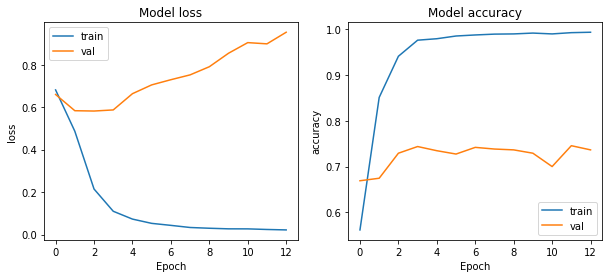

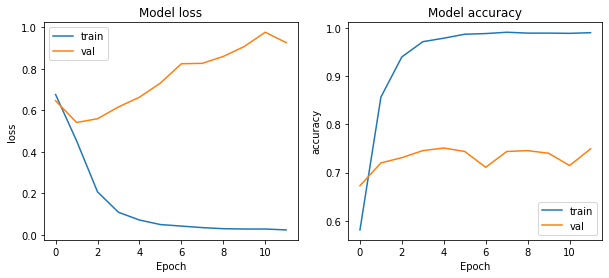

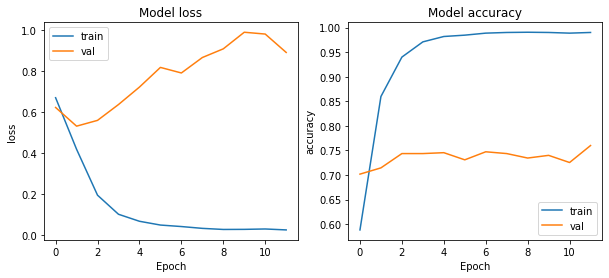

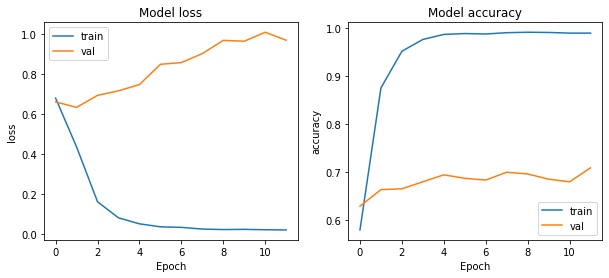

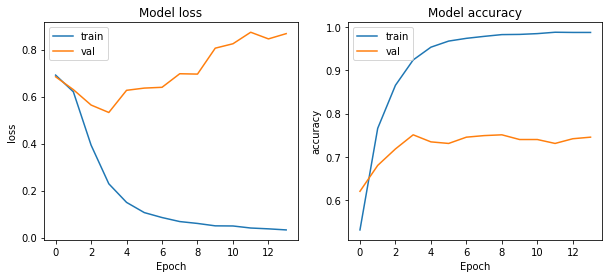

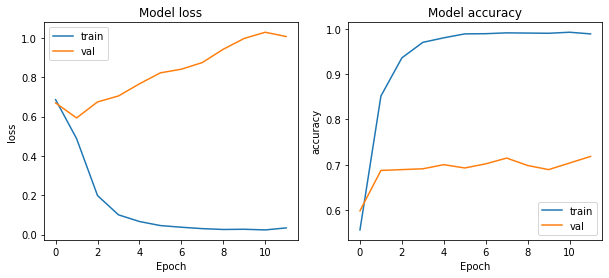

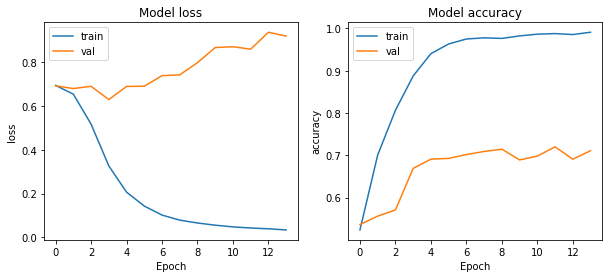

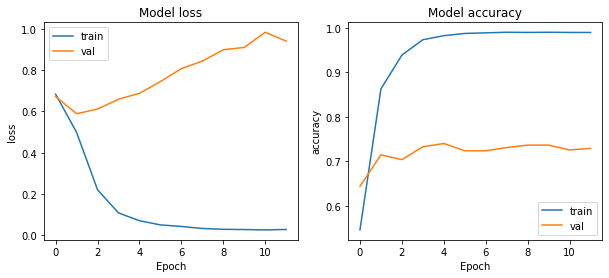

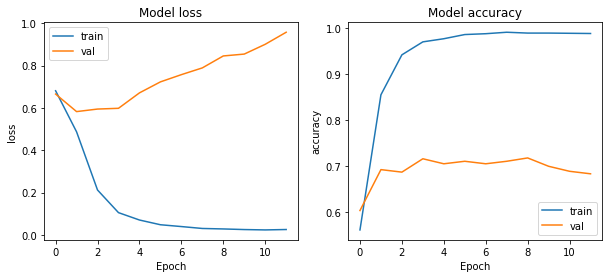

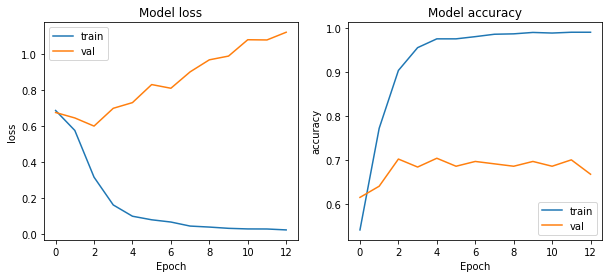

In [0]:
# Random Grid Search of size 10
np.random.seed(42)
tf.random.set_seed(42)

num_combinations = 10 # Number of hyperparameter combinations

histories = []
models = []
embedding_sizes = []
rnn_num_neurons = []
dropouts = []

for _ in np.arange(num_combinations):
  # Random Sample Hyperparameter Space
  embeding_size = np.random.randint(10, 100)
  rnn_num_neuron = np.random.randint(5, 50)
  dropout = np.random.uniform(0, 0.4)
  print(f"Embedding Size: {embeding_size}, RNN Neurons: {rnn_num_neuron}, Dropout: {dropout}")

  # Build Model and Train
  model = create_simple_rnn(vocabulary_size=vocabulary_size, embedding_size=embeding_size, time_steps=time_steps, rnn_neurons=rnn_num_neuron, dropout=dropout)
  print(model.summary())
  history = model.fit(X_train_encoded, y_train, validation_data=(X_test_encoded, y_test), epochs=50, batch_size=32, callbacks=[es, checkpoint])
  plot_metrics(history, metrics=['loss', 'accuracy'])

  # Housekeeping
  histories.append(history)
  models.append(model)
  embedding_sizes.append(embeding_size)
  rnn_num_neurons.append(rnn_num_neuron)
  dropouts.append(dropout)

In [0]:
best_train_accuracies = [max(history.history['accuracy']) for history in histories]
best_test_accuracies = [max(history.history['val_accuracy']) for history in histories]
print(f"Train Accuracies: {best_train_accuracies}")
print(f"Test Accuracies: {best_test_accuracies}")

Train Accuracies: [0.9927140474319458, 0.9908925294876099, 0.9904371500015259, 0.9918032884597778, 0.9886156916618347, 0.9922586679458618, 0.9908925294876099, 0.9904371500015259, 0.9918032884597778, 0.9904371500015259]
Test Accuracies: [0.7454545497894287, 0.7509090900421143, 0.7599999904632568, 0.7090908885002136, 0.7509090900421143, 0.7181817889213562, 0.7200000286102295, 0.7400000095367432, 0.7181817889213562, 0.7036363482475281]


In [0]:
results = pd.DataFrame({
    'embedding_size':embedding_sizes,
    'rnn_neurons': rnn_num_neurons,
    'dropout': dropouts,
    'best_train_acc': best_train_accuracies,
    'best_test_acc': best_test_accuracies
  })
results

,embedding_size,rnn_neurons,dropout,best_train_acc,best_test_acc
0,61,33,0.073374,0.992714,0.745455
1,81,25,0.062407,0.990893,0.750909
2,92,27,0.023233,0.990437,0.760000
3,97,40,0.057147,0.991803,0.709091
4,12,26,0.022565,0.988616,0.750909
5,97,48,0.375421,0.992259,0.718182
6,11,25,0.246993,0.990893,0.720000
7,67,26,0.002827,0.990437,0.740000
8,98,31,0.244741,0.991803,0.718182
9,51,32,0.389502,0.990437,0.703636
